In [1]:
import os
import sys
import h5py
import numpy as np
import matplotlib as mpl
path = '/tigress/ruix/vis/'
os.chdir(path)
import matplotlib.pyplot as plt
#plt.style.use('apw-notebook.mplstyle')
%matplotlib inline
%run LoadNotebook
import DataProcess as R
from scipy.integrate import ode

importing Jupyter notebook from DataProcess.ipynb


In [2]:
import os
path = '/tigress/ruix/simu/1dang70mass100new/output1/'
#sys.path.append(path)
os.chdir(path)

In [7]:
def Plot_Spectrum(index, sp, xL,xR,GammaMin,GammaMax,shock=1,frame=''):

    #Dt = R.readparam('time',ind+1)-R.readparam('time',index)
    mom,gamma,momedist,mompdist,edist,pdist = R.spect1d(index,xL,xR,shock,frame)
    mom,dat = R.power_law_fit(index,sp, xL,xR,GammaMin,GammaMax)
    fig,ax = plt.subplots(2,sharex=False)

    # electron/ion energy spectrum
    #ax[0].loglog(gamma,edist,linewidth=2,linestyle='-',color=mpl.cm.autumn(i/ float(nsteps)))
    ax[0].loglog(gamma,edist)
    ax[0].loglog(gamma,pdist)
    # electron/ion momentum spectrum
    ax[1].loglog(mom,momedist)
    ax[1].loglog(mom,mompdist)
    
    DelGam = 0.0017
    mom,fmom = R.SetT(path,sp, DelGam, index, spect_type=1)
    ax[1].loglog(mom,dat)

    ax[0].set_ylabel(r'$E(dn/dE)/n$')
    ax[0].set_xlabel(r'$\gamma-1$')
    ax[1].set_ylabel(r'$p^4 f(p)$')
    ax[1].set_xlabel(r'$\gamma\beta$')

    ax[0].axis([1e-3,1e2,1e-4,1e-1])
    ax[1].axis([1e-2,1e2,1e-6,1e0])
    #plt.show()

('slope: ', -4.2663026513039908)


TypeError: SetT() got multiple values for keyword argument 'spect_type'

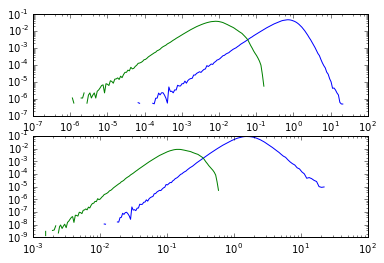

In [8]:
#inj = R.inj_efficiency(path,ind=50,xL=-1000,xR=-500,crit=2)
Plot_Spectrum(index=50,sp='e', xL=-1000,xR=-500,GammaMin=2,GammaMax=15,shock=1,frame='')

#print ('inj=',inj)

('slope: ', -6.9759626212420871)


TypeError: SetT() got multiple values for keyword argument 'spect_type'

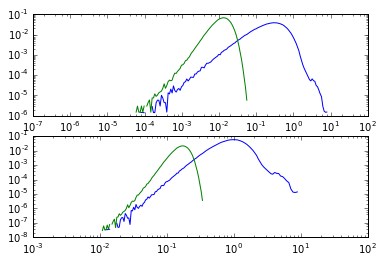

In [9]:
inj = R.inj_efficiency(ind=7,xL=500,xR=1000,crit=2)
Plot_Spectrum(index=7,sp='e', xL=500,xR=1000,GammaMin=1,GammaMax=2,shock=1,frame='')
print ('inj=',inj)

### Semi-analytical theory of CR-modified shock (from Blasi 2002)

In [10]:
def model(x, t, a, rsub, rtot):
    p     = t
    u     = x[0]
    dudp  = x[1]
    
    coef  = -(gamma+1)*u**(-(gamma+2))/(m0**2-u**(-(gamma+1)))*dudp
    vp    = 1./np.sqrt(1.+1./p**2)
    dvp   = (1+1./p**2)**(-1.5)/p**3
    coef += 3/p +dvp/vp
    coef += -rtot/(rtot*u-1)*dudp - 3*rtot*u/p/(rtot*u-1)
    
    dudp2 = dudp*coef
    
    return [dudp,dudp2]

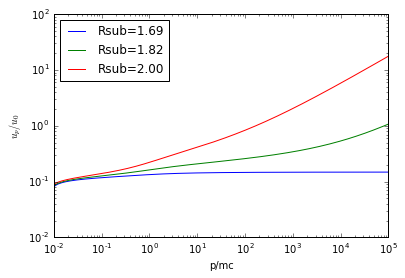

In [11]:
from scipy.integrate import odeint
m0   = 43;
eta  = 4e-3;
c_u0 = 60; 
gamma= 5/3.0;
num  = 3
for i in range(num):
    a    = [0.08,0.084,0.09] # a = u1/u0
    m1   = m0*a[i]**((gamma + 1.)/2.);
    rsub = (gamma + 1.)*m1**2/((gamma - 1.)*m1**2 + 2.)
    qs   = 3.*rsub/(rsub - 1.);
    rtot = m0**(2./(gamma+1))*(((gamma+1)*rsub**gamma-(gamma-1)*rsub**(gamma+1.))/2.)**(1./(gamma + 1.)) 
    if rsub<1. or rsub>4:
        print('Error in Rsub!')
        continue

    p = np.logspace(-2,5,200)
    # initial condition
    u0    = a[i]
    dudp0 = 1./3*eta*qs*rtot/rsub/np.sqrt(1.+1./p[0]**2)*c_u0**2/((rtot*a[i]-1)/(rsub-1))/(1.-a[i]**(-(gamma+1))/m0**2)

    up = odeint(model,[u0,dudp0],p,args=(a[i], rsub, rtot))
    plt.loglog(p,up[:,0],label='Rsub={:1.2f}'.format(rsub))
    plt.xlabel('p/mc')
    plt.ylabel(r'$u_p/u_0$')
    plt.legend(loc=2)
    

0.643296740625 0.000542723526777 0.000843659686896


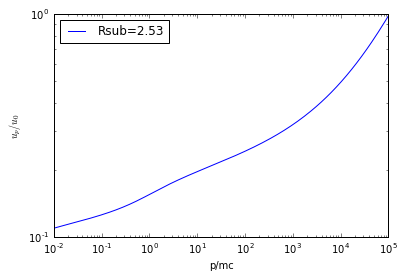

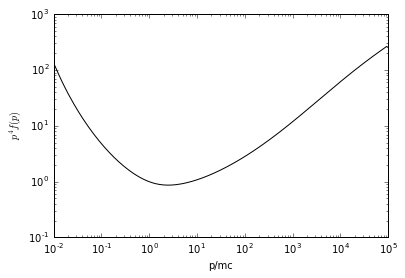

In [12]:
'''
Compare with Blasi's paper
'''
m0   = 43;
eta  = 1e-3;
c_u0 = 60; 
gamma= 5/3.0;
num  = 150
for i in range(num):
    a    = 0.06+i*5e-4 # a = u1/u0
    m1   = m0*a**((gamma + 1.)/2.);
    rsub = (gamma + 1.)*m1**2/((gamma - 1.)*m1**2 + 2.)
    qs   = 3.*rsub/(rsub - 1.);
    rtot = m0**(2./(gamma+1))*(((gamma+1)*rsub**gamma-(gamma-1)*rsub**(gamma+1.))/2.)**(1./(gamma + 1.)) 
    if rsub<1. or rsub>4:
        print('Error in Rsub!')
        continue

    p = np.logspace(-2,5,200)
    # initial condition
    u0    = a
    dudp0 = 1./3*eta*qs*rtot/rsub/np.sqrt(1.+1./p[0]**2)*c_u0**2/((rtot*a-1)/(rsub-1))/(1.-a**(-(gamma+1))/m0**2)

    up = odeint(model,[u0,dudp0],p,args=(a, rsub, rtot))
    if up[-1,0]>0.95 and up[-1,0]<1.05:
        plt.loglog(p,up[:,0],label='Rsub={:1.2f}'.format(rsub))
        plt.xlabel('p/mc')
        plt.ylabel(r'$u_p/u_0$')
        plt.legend(loc=2)
        break
    
### calculate spectrum
Qp = np.linspace(0,1,len(up))
for i in range(len(up)):
    if i==0:
        dup = (up[i+1,0]-up[i,0])/(p[i+1]-p[i])
        print dup, (up[i+1,0]-up[i,0]), (p[i+1]-p[i])
    elif i==len(up)-1:
        dup = (up[i,0]-up[i-1,0])/(p[i]-p[i-1])
    else:
        dup = (up[i+1,0]-up[i-1,0])/(p[i+1]-p[i-1])
        
    Qp[i] = -3*up[i,0]/(up[i,0]-1/rtot) - p[i]/(up[i,0]-1/rtot)*dup
plt.figure(2)
plt.loglog(p,p**(Qp+4),'k')  
plt.xlabel('p/mc')
plt.ylabel(r'$p^4 f(p)$')

('c_u0', 46.664000000000001)
('c_u0', 51.6)
('Rsub', 3.4400975229047526, 'Rtot', 3.8566115727631725)
0.0436478042332 7.71745348598e-05 0.00176811952435


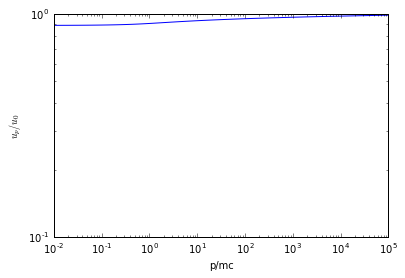

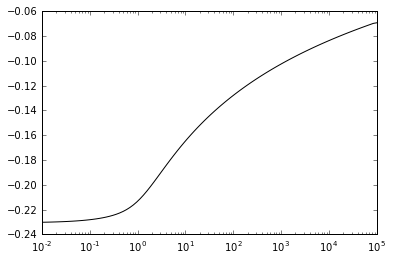

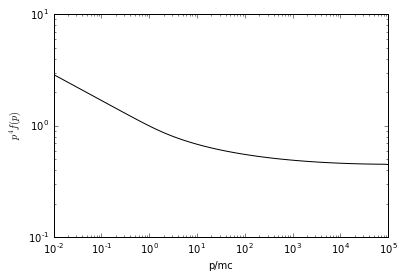

In [13]:
'''
Additional check
'''
m0   = 5;
eta  = 1e-3;
Tk   = 1e8
c_u0 = 2.3332e6/np.sqrt(Tk)/m0
print ('c_u0',c_u0)
c_u0 = 60./10*43/5
print ('c_u0',c_u0)
gamma= 5/3.0
num  = 2000
for i in range(num):
    a    = 0.01+i*5e-4 # a = u1/u0
    m1   = m0*a**((gamma + 1.)/2.);
    rsub = (gamma + 1.)*m1**2/((gamma - 1.)*m1**2 + 2.)
    qs   = 3.*rsub/(rsub - 1.);
    rtot = m0**(2./(gamma+1))*(((gamma+1)*rsub**gamma-(gamma-1)*rsub**(gamma+1.))/2.)**(1./(gamma + 1.)) 
    if rsub<1. or rsub>4:
        #print('Error in Rsub!')
        continue

    p = np.logspace(-2,5,100)
    # initial condition
    u0    = a
    dudp0 = 1./3*eta*qs*rtot/rsub/np.sqrt(1.+1./p[0]**2)*c_u0**2/((rtot*a-1)/(rsub-1))/(1.-a**(-(gamma+1))/m0**2)

    up = odeint(model,[u0,dudp0],p,args=(a, rsub, rtot))
    
    if up[-1,0]>0.99 and up[-1,0]<1.01:
    #if 1>0:
        #plt.loglog(p,up[:,0],label='Rsub={:1.2f}'.format(rsub))
        print ('Rsub',rsub,'Rtot',rtot)
        plt.loglog(p,up[:,0])
        plt.xlabel('p/mc')
        plt.ylabel(r'$u_p/u_0$')
        #plt.legend(loc=2)
        break
    
### calculate spectrum
Qp = np.linspace(0,1,len(up))
for i in range(len(up)):
    if i==0:
        dup = (up[i+1,0]-up[i,0])/(p[i+1]-p[i])
        print dup, (up[i+1,0]-up[i,0]), (p[i+1]-p[i])
    elif i==len(up)-1:
        dup = (up[i,0]-up[i-1,0])/(p[i]-p[i-1])
    else:
        dup = (up[i+1,0]-up[i-1,0])/(p[i+1]-p[i-1])
        
    Qp[i] = -3*up[i,0]/(up[i,0]-1/rtot) - p[i]/(up[i,0]-1/rtot)*dup
    
plt.figure(2)
plt.semilogx(p,Qp+4,'k') 
plt.figure(3)
plt.loglog(p,p**(Qp+4),'k')  
plt.xlabel('p/mc')
plt.ylabel(r'$p^4 f(p)$')

/usr/licensed/anaconda/4.1.1/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


('Rsub', 2.458354369646168, 'Rtot', 3.1157850058886787)
0.525552041729 0.00377826295908 0.00718913192051


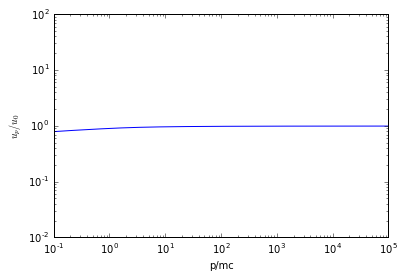

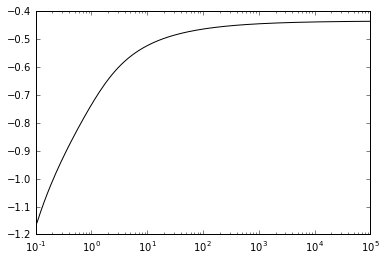

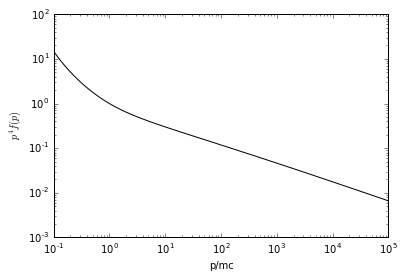

In [14]:
'''
For our shock problem
'''
ma   =  R.cal_param('MachUp')
m0   = 3;
eta  = 1e-2;
Tk   = 1e9
c_u0 = 1/(0.15-0.08)
gamma= 5/3.0
num  = 1000
for i in range(num):
    a    = 0.1+i*1e-3 # a = u1/u0
    m1   = m0*a**((gamma + 1.)/2.);
    rsub = (gamma + 1.)*m1**2/((gamma - 1.)*m1**2 + 2.)
    qs   = 3.*rsub/(rsub - 1.);
    rtot = m0**(2./(gamma+1))*(((gamma+1)*rsub**gamma-(gamma-1)*rsub**(gamma+1.))/2.)**(1./(gamma + 1.)) 
    if rsub<1. or rsub>4:
        #print('Error in Rsub!')
        continue

    p = np.logspace(-1,5,200)
    # initial condition
    u0    = a
    dudp0 = 1./3*eta*qs*rtot/rsub/np.sqrt(1.+1./p[0]**2)*c_u0**2/((rtot*a-1)/(rsub-1))/(1.-a**(-(gamma+1))/m0**2)

    up = odeint(model,[u0,dudp0],p,args=(a, rsub, rtot))
    
    if up[-1,0]>0.99 and up[-1,0]<1.02:
    #if 1>0:
        #plt.loglog(p,up[:,0],label='Rsub={:1.2f}'.format(rsub))

        plt.loglog(p,up[:,0])
        plt.xlabel('p/mc')
        plt.ylabel(r'$u_p/u_0$')
        plt.axis([p[0],p[-1],1e-2,100])
        #plt.legend(loc=2)
        break
        
print ('Rsub',rsub,'Rtot',rtot)    
### calculate spectrum
Qp = np.linspace(0,1,len(up))
for i in range(len(up)):
    if i==0:
        dup = (up[i+1,0]-up[i,0])/(p[i+1]-p[i])
        print dup, (up[i+1,0]-up[i,0]), (p[i+1]-p[i])
    elif i==len(up)-1:
        dup = (up[i,0]-up[i-1,0])/(p[i]-p[i-1])
    else:
        dup = (up[i+1,0]-up[i-1,0])/(p[i+1]-p[i-1])
        
    Qp[i] = -3*up[i,0]/(up[i,0]-1/rtot) - p[i]/(up[i,0]-1/rtot)*dup
    
plt.figure(2)
plt.semilogx(p,Qp+4,'k') 
plt.figure(3)
plt.loglog(p,p**(Qp+4),'k')  
plt.xlabel('p/mc')
plt.ylabel(r'$p^4 f(p)$')

In [ ]:
'''
CR-modified shock spectrum with seed particles
'''



